Foreground Modeling using DMD tutorial for the Paper [Compressed dynamic mode decomposition for background modeling](https://arxiv.org/abs/1512.04205) by Erichson et al.

This supplements the presentation for APPM 5720: Data Driven Modeling.
Authors: Josh Myers-Dean, Leonardo Orozco, and Wenhao Wang

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joshmyersdean/DMD_Background_Modeling/blob/main/dmd.ipynb)

In [55]:
import os
print('Downloading data...')
if not os.path.exists('SegTrackv2'):
  !wget https://web.engr.oregonstate.edu/~lif/SegTrack2/SegTrackv2.zip >& /dev/null
  !unzip SegTrackv2.zip >& /dev/null
  print('Done!')
else:
  print('Data already present')

Data already present


In [56]:
%pip install pydmd

In [57]:
from pydmd import CDMD, DMD
import matplotlib.pyplot as plt
from matplotlib import style
plt.gray()
style.use('tableau-colorblind10')
from matplotlib import animation
from IPython.display import HTML
import numpy as np
import pandas as pd
import cv2
from typing import Tuple

<Figure size 432x288 with 0 Axes>

### Below we can peak at the data to examine the amount of frames per object video. Note that the videos with small number frames will most likely have poor results. It is recommended to use the 'Frog' and 'Worm' videos.

In [58]:
videos = sorted(os.listdir('SegTrackv2/JPEGImages'))[1:]
vid_metadata = {}
for i in videos:
  vid_metadata[i] = len(os.listdir(f'SegTrackv2/JPEGImages/{i}'))
df = pd.DataFrame(vid_metadata.items(), columns=['Name', 'Number of Frames'])
valid = ['birds_of_paradise', 'birdfall', 'frog', 'monkey', 'parachute', \
         'soldier', 'worm']
df = df[df.Name.isin(valid)]
display(df)

,Name,Number of Frames
1,birdfall,30
5,frog,279
8,monkey,31
10,parachute,51
12,soldier,32
13,worm,243


In [59]:
OBJ = 'frog'
assert OBJ in df['Name'].to_list(), 'Object not found in dataset'

### Below are all the methods we will need for the tutorial.

In [60]:
def get_video_dmd(
    object: str='frog', noise: bool=False, noise_amt: float=.01
    ) -> Tuple[np.ndarray, Tuple[int, int]]:
  '''
  Retreives a video in matrix format (i.e., each column is a frame)

  Parameters
  ----------
  object : 
    name of video
  noise : 
    boolean to use noise or not
  noise_amt :
    standard deviation for noise ~ N(0, noise_amt)

  Returns
  -------
  Tuple:
    Matrix representation of the video
    Original shape of frame
  
  '''
  imgs = []
  jpeg_dir = 'SegTrackv2/JPEGImages/'
  shape = None
  for i in sorted(os.listdir(f'{jpeg_dir}{object}')):
    tmp = cv2.imread(f'{jpeg_dir}{object}/{i}', cv2.IMREAD_GRAYSCALE)
    shape = tmp.shape
    tmp = tmp.reshape(-1).astype(np.float32) / 255
    imgs.append(tmp)
  vid = np.vstack(imgs).T
  if noise:
    vid += np.random.normal(0, noise_amt, vid.shape)
    vid = vid.clip(0,1)
  return np.vstack(imgs).T, shape

def get_video(object: str ='frog') -> np.ndarray:
  '''
  Retreives a video in tensor format (i.e., frames x heigh x width)

  Parameters
  ----------
  object : 
    name of video

  Returns
  -------
  Numpy array:
    Tensor representation of the video
  
  '''
  imgs = []
  jpeg_dir = 'SegTrackv2/JPEGImages/'
  for i in sorted(os.listdir(f'{jpeg_dir}{object}')):
    tmp = cv2.imread(f'{jpeg_dir}{object}/{i}', cv2.IMREAD_GRAYSCALE)
    tmp = tmp.astype(np.float32) / 255
    imgs.append(tmp)
  return np.asarray(imgs)



def calc_iou(pred: np.ndarray, truth: np.ndarray, thresh: float =.1) -> float:
  '''
  Helper method to calculate IoU for single frame

  Parameters
  ----------
  pred : 
    background subtracted video
  truth : 
    segmentation ground truth
  thresh :
    cut off for deciding if a pixel is foreground

  Returns
  -------
  float:
    IoU of  a frame
  
  '''
  pred[pred < thresh] = 0
  pred[pred >= thresh] = 1
  intersection = np.logical_and(pred, truth).sum()
  union = np.logical_or(pred, truth).sum()
  return intersection / union if union > 0 else 0



def calc_miou(pred, truth, thresh = .1) -> float:
  '''
  Calculate average IoU for a video

  Parameters
  ----------
  pred : 
    background subtracted video
  truth : 
    segmentation ground truth
  thresh :
    cut off for deciding if a pixel is foreground

  Returns
  -------
  float:
    mIoU of  a video
  
  '''
  assert pred.shape == truth.shape, 'Pred and truth must be same shape'
  pred = pred.copy()
  miou = 0
  for i in range(pred.shape[0]):
    iou = calc_iou(pred[i,:,:], truth[i,:,:], thresh=thresh)
    miou += iou
  return miou / pred.shape[0]



def f1_score(y_true: np.ndarray, y_pred: np.ndarray, beta: int=1) -> float:
    '''
    Calculate F1 score.
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Parameters
    ----------
    y_true : 
      segmentation ground truth

    y_pred : 
      background subtracted video

    Returns
    -------
    float:
      f1 score of a video
      
    '''
    
    tp = (y_true * y_pred).sum()
    tn = ((1 - y_true) * (1 - y_pred)).sum()
    fp = ((1 - y_true) * y_pred).sum()
    fn = (y_true * (1 - y_pred)).sum()
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = (1 + beta**2)* (precision*recall)
    f1 /= (beta**2 * precision + recall + epsilon)
    return f1 



def calc_f1(pred: np.ndarray, truth: np.ndarray, thresh: float = .1) -> float:
  '''
  Calculate f1 score for a video

  Parameters
  ----------
  pred : 
    background subtracted video
  truth : 
    segmentation ground truth
  thresh :
    cut off for deciding if a pixel is foreground

  Returns
  -------
  float:
    f1 score of a video
  
  '''
  assert pred.shape == truth.shape, 'Pred and truth must be same shape'
  pred = pred.copy()
  truth = truth.copy()
  pred[pred < thresh] = 0
  pred[pred >= thresh] = 1
  pred = pred.astype(np.uint8)
  truth = truth.astype(np.uint8)
  return f1_score(truth.flatten(), pred.flatten())

def get_gt_video(object: str='frog') -> np.ndarray:
  '''
  Retreives a video of GT in tensor format (i.e., frames x heigh x width)

  Parameters
  ----------
  object : 
    name of video

  Returns
  -------
  Numpy array:
    Tensor representation of the GT video
  
  '''
  imgs = []
  jpeg_dir = 'SegTrackv2/GroundTruth/'
  gt_dir = 'SegTrackv2/JPEGImages/'
  jpeg_list = sorted(os.listdir(f'{jpeg_dir}{object}'))
  gt_list = sorted(os.listdir(f'{gt_dir}{object}'))
  valid = list(set(jpeg_list).intersection(set(gt_list)))
  for i in sorted(valid):
    tmp = f'{gt_dir}/{i}'
    tmp = cv2.imread(f'{jpeg_dir}{object}/{i}', cv2.IMREAD_GRAYSCALE)
    tmp = tmp.astype(np.float32) / 255
    imgs.append(tmp)
  return np.asarray(imgs)

def play_video(object: str='frog', interval: int=10) -> None:
  '''
  Helper function to play original video

  Parameters
  ----------
  object : 
    name of video
  interval :
    delay in ms between frames
  
  '''
  video = get_video(object=object)

  fig = plt.figure()
  im = plt.imshow(video[0,:,:])

  plt.close() # this is required to not display the generated image

  def init():
      im.set_data(video[0,:,:])

  def animate(i):
      im.set_data(video[i,:,:])
      return im

  anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                 frames=video.shape[0], interval=interval)
  return HTML(anim.to_html5_video())

def play_gt_video(object: str='frog', interval: int=10):
  '''
  Helper function to play GT video

  Parameters
  ----------
  object : 
    name of video
  interval :
    delay in ms between frames
  
  '''
  video = get_gt_video(object=object)

  fig = plt.figure()
  im = plt.imshow(video[0,:,:])

  plt.close() # this is required to not display the generated image

  def init():
      im.set_data(video[0,:,:])

  def animate(i):
      im.set_data(video[i,:,:])
      return im

  anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                 frames=video.shape[0], interval=interval)
  return HTML(anim.to_html5_video())

def get_video_removed(video: np.ndarray, bg: np.ndarray) -> np.ndarray:
  '''
  Helper function to subtract background from video

  Parameters
  ----------
  video : 
    original video
  bg :
    background model

  Returns
  -------
  np.ndarray :
    predicted foreground
  
  '''
  print(video.shape)
  for i in range(video.shape[0]):
    video[i,:,:] -= bg
  return video

def play_video_removed(bg: np.ndarray, 
                       object: str='frog', 
                       mask: bool=False, 
                       interval: int=10, 
                       thresh: float=.1) -> None:
  '''
  Helper function to play foreground video

  Parameters
  ----------
  bg : 
    background model
  object :
    name of video
  mask :
    Show binary version
  interval :
    delay in ms between frames
  thresh :
    value to decide if pixel is foreground
  
  '''
  video = get_video(object=object)

  fig = plt.figure()
  subbed = video[0,:,:]-bg
  if mask:
    subbed[subbed > thresh] = 1
    subbed[subbed <= thresh] = 0
  else:
    subbed = subbed.clip(0, 1)
  im = plt.imshow(subbed)

  plt.close() # this is required to not display the generated image

  def init():
      subbed = video[0,:,:]-bg
      if mask:
        subbed[subbed > thresh] = 1
        subbed[subbed <= thresh] = 0
      else:
        subbed = subbed.clip(0, 1)
      im.set_data(subbed)

  def animate(i):
      subbed = video[i,:,:]-bg
      if mask:
        subbed[subbed > thresh] = 1
        subbed[subbed <= thresh] = 0
      else:
        subbed = subbed.clip(0, 1)
      im.set_data(subbed)
      return im

  anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                frames=video.shape[0], interval=interval)
  return HTML(anim.to_html5_video())

## Let's peak at the data!

In [61]:
'''
play the video we will model,
change interval based on video size
'''
play_video(OBJ, interval=10) 

In [62]:
# show gt video
play_gt_video(OBJ, interval=10)

### Now time to fit our video to (c)DMD, add noise, tinker with SVD rank, etc. We can also visualize our background model! Since we average the first $K$ modes, we can visualize how our model changes wrt $K$. Recall that each column of our matrix will be a frame in the video and unless we have a long video, the system will be overdetermined.

In [63]:
use_noise = False
noise = .01
video, shape = get_video_dmd(OBJ, use_noise, noise) # get video
print(f'Condition number of video matrix is {np.linalg.cond(video): .3f}')

Condition number of video matrix is  40.923


In [64]:
comp = True # use compressed DMD
svd_rank = 0 # rank=0 will automatically detect rank, try other values next!
optim = True # Use optimized DMD
compression = ['linear', 'sparse', 'uniform', 'sample']
cmat = compression[2] # compression matrix

if comp:
  dmd = CDMD(svd_rank=svd_rank, opt=optim, compression_matrix=cmat)
else:
  dmd = DMD(svd_rank=svd_rank, opt=optim)

In [65]:
%%time
'''
See https://mathlab.github.io/PyDMD/cdmd.html for more CDMD params
'''
dmd.fit(video)

CPU times: user 816 ms, sys: 288 ms, total: 1.1 s
Wall time: 1.08 s


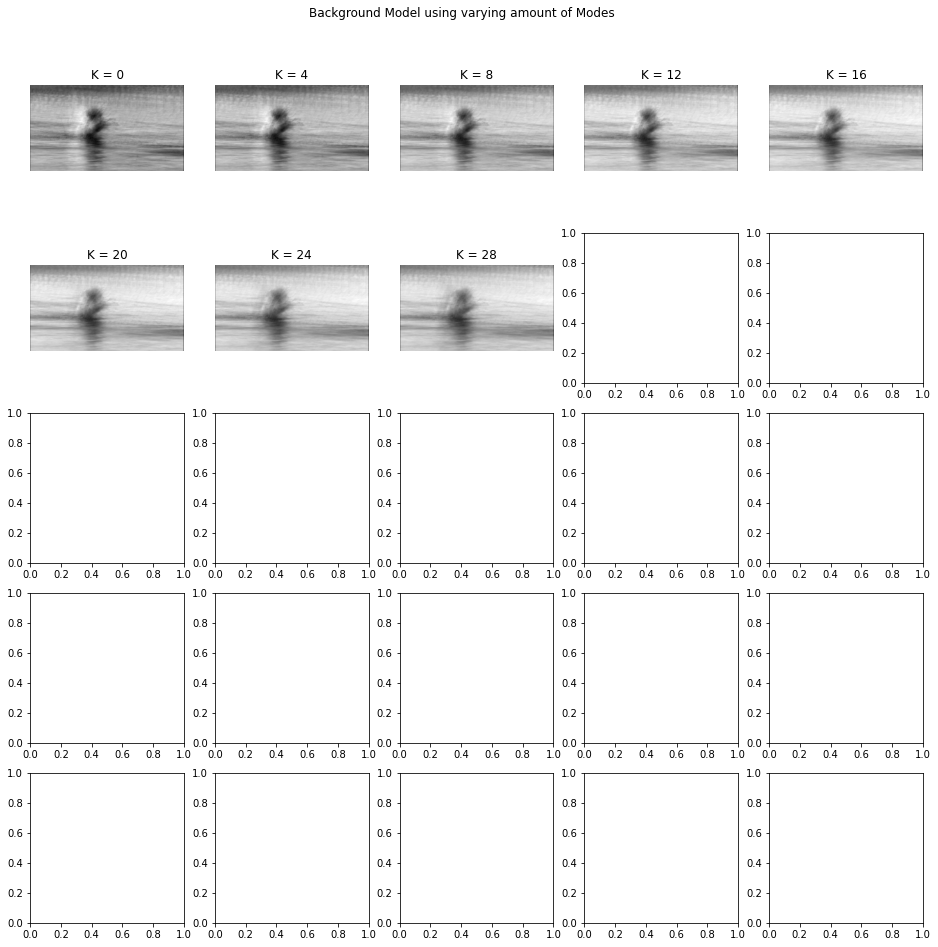

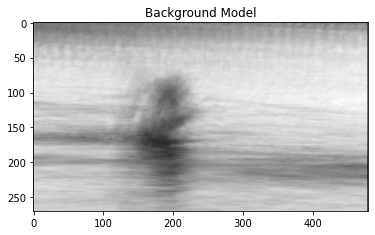

In [66]:
modes = dmd.reconstructed_data.T.reshape(video.shape[1], shape[0], shape[1])

# Try changing the value of K, amount of modes we use
K = min(100, modes.shape[0])

modes = np.abs(modes) # deal with complex values
bg = np.zeros_like(modes[0,:,:])

fig, axes = plt.subplots(5, 5, figsize=(16,16))
axes = axes.flatten()

idx = 0
for k in range(K):
  bg += modes[k,:,:]
  if k % 4 == 0:
    if idx >= len(axes):
      continue
    axes[idx].axis('off')
    axes[idx].imshow(bg / (k+1))
    axes[idx].set_title(f'K = {k}')
    idx += 1
plt.suptitle('Background Model using varying amount of Modes', y=.92)
plt.show()
print()
bg /= K
plt.imshow(bg)
plt.title('Background Model')
plt.show()

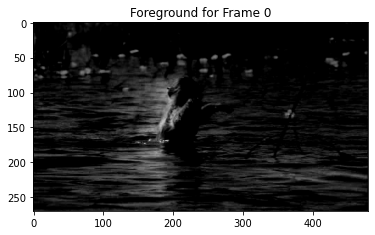

In [67]:
# show an example frame
tmp = get_video(OBJ)
img = tmp[0,:,:]
fg = (img-bg).clip(0,1)
plt.title('Foreground for Frame 0')
plt.imshow(fg)
plt.show()

## Now time to get some quanitative (and qualitative) results! We will examine mean intersection over union (mIoU) and F1 score, respectively. We can also visualize the eigenvalues, modes, and dynamics of our video computed from DMD.

In [68]:
video_removed = get_video_removed(tmp, bg).clip(0,1)
gt = get_gt_video(OBJ)
print(video_removed.shape, gt.shape)

(31, 270, 480)
(31, 270, 480) (31, 270, 480)


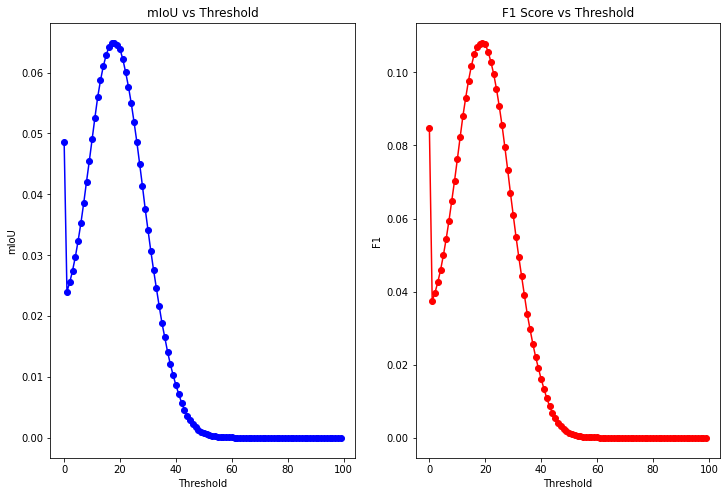

In [69]:
'''
calculate mIoU and F1 as a function of threshold value, takes a bit to run
Images are saved in the format `results_{object name}_{svd rank}_{use compressed}_{use optimized}_{K}.png`
'''
 # change this to your object
mious = []
f1s = []
for thresh in np.linspace(0,1,100):
  mious.append(calc_miou(video_removed, gt, thresh=thresh))
  f1s.append(calc_f1(video_removed, gt, thresh=thresh))

fig, axes = plt.subplots(1,2, figsize=(12,8))

axes[0].plot(mious, 'bo-')
axes[0].set_title('mIoU vs Threshold')
axes[0].set_ylabel('mIoU')
axes[0].set_xlabel('Threshold')

axes[1].plot(f1s, 'ro-')
axes[1].set_title('F1 Score vs Threshold')
axes[1].set_ylabel('F1')
axes[1].set_xlabel('Threshold')
plt.savefig(f'results_{OBJ}_{svd_rank}_{comp}_{optim}_{K}.png')
plt.show()

In [70]:
# change threshold (in [0,1]) to see visual examples
use_mask = False # show binary output or not, if False thresh doesn't matter
play_video_removed(bg, OBJ, mask=use_mask, thresh=.03)

Eigenvalue 1.0004442078330118: distance from unit circle  0.00089
Eigenvalue 0.9425868944784453: distance from unit circle  0.11153


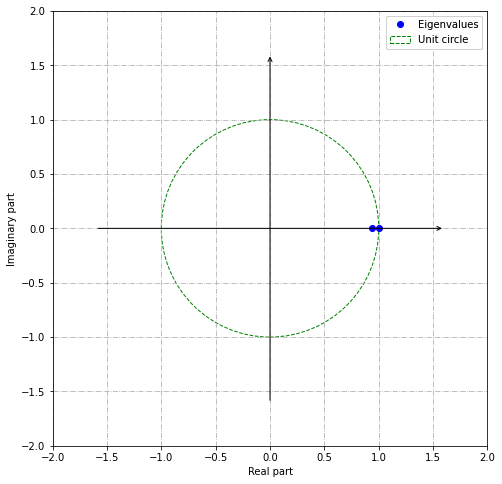

In [71]:
# Show first min(6, number of eigs) eigenvalues distances, plot all

for idx, eig in enumerate(dmd.eigs):
  if idx > 5:
    break
  print(f'Eigenvalue {eig}: distance from unit circle {np.abs(eig.imag**2+eig.real**2-1): .5f}')

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

### Now we can plot the modes and the dynamics! The modes are hard to disentangle when SVD rank is larger than 3 but we can see the slow varying dynamic which is our background mode!

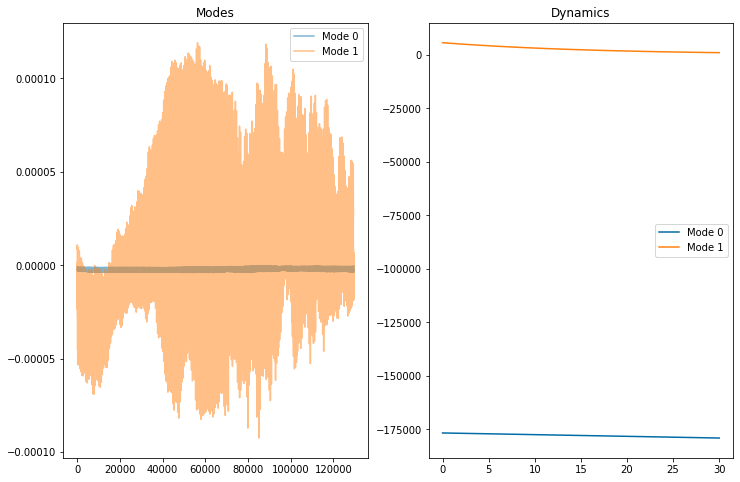

In [72]:
# plot modes and dynamics, only label first min(6, num modes) modes

fig, axes = plt.subplots(1, 2, figsize=(12,8))
for idx, mode in enumerate(dmd.modes.T):
    if idx > 5:
      axes[0].plot(mode.real, alpha=.5, label='_nolegend_')
    else:
      axes[0].plot(mode.real, alpha=.5, label=f'Mode {idx}')

axes[0].set_title('Modes')
axes[0].legend()

for idx, dynamic in enumerate(dmd.dynamics):
  if idx > 5:
    axes[1].plot(dynamic.real, label='_nolegend_')
  else:
    axes[1].plot(dynamic.real, label=f'Mode {idx}')
axes[1].set_title('Dynamics')
axes[1].legend()

plt.show()